In [145]:
import calcephpy as efm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import constants # мои константы
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import scipy.linalg
import subprocess as sb
import decimal
from tqdm import tqdm

# Задача 1. Научиться пользоваться эфемеридами.
Согласно документации на сайте [ИПА РАН](http://iaaras.ru/dept/ephemeris/epm/), существует библиотека **CALCEPH** с удобной оболочкой для Python ([док](https://www.imcce.fr/content/medias/recherche/equipes/asd/calceph/calceph_python.pdf)), которая позволяет легко рассчитывать положения небесных тел на основе эфемерид, которые так же можно найти на сайте ИПА РАН. Я выбрал набор эфемерид [EPM2017](http://iaaras.ru/en/dept/ephemeris/epm/2017/) и скачал их в формате .bsp, так называемый "*SPICE format*". Исходя из документации, в этом формате каким-то образом записаны коэффициенты полиномов Чебышёва для аппроксимации положений небесных тел в **BCRS** в шакле времени **TDB** на основе могочисленных наблюдений и моделирования. *EPM2017* покрывает временной промежуток с 1787 г. по 2214 г.  
Для рассчётов Юлианских дней используется [онлайн-калькулятор](https://planetcalc.ru/503/).

### Упр. 1: получить траекторию Луны относительно Земли за 27 дней.

In [146]:
# Открываем файл эфемерид
f = efm.CalcephBin.open("epm2017.bsp")

In [147]:
# Задаю время, в которое я хочу получить положение.
jd0 = 2459155 # 01.11.2020 12:00 UTC
step = 1/24 # Час
N = 24 * 27 # Число точек
dt = np.array([i * step for i in range(0, N)])
# Из-за особенностей работы, методы для рассчёта положения требуют отдельно целую и дробную части времени в Юлианских днях
jd0 = 2459155 + dt // 1
dt = dt % 1

In [148]:
# Рассчёт положения Луны относительно Земли. Входые данные:
# Целая часть даты в Юл. днях, дробная часть даты в Юл. днях
# Цель рассчёта (Луна), точка в которой располагается центр СК (Земля)
# Единицы измерения: километры, секунды, последний параметр указывает индексацию небесных тел NaifID
PV = f.compute_unit(jd0, dt, efm.NaifId.MOON, efm.NaifId.EARTH, 
                    efm.Constants.UNIT_KM + efm.Constants.UNIT_SEC  + efm.Constants.USE_NAIFID)
# Возвращает массив (list) из шести numpy массивов: x, y, z, Vx, Vy, Vz
PV = np.array(PV)

rL = PV[:3]*1000 # в метры/сек
VL = PV[3:]*1000

# Проверка расчётов. Перигей луны - 356 400 км, апогей - 406 700 км
a = np.linalg.norm(rL, axis = 0)
print("Max distance:", np.max(a)/1000, "km", "\nMin distance:", np.min(a)/1000, "km")

Max distance: 405893.68373504345 km 
Min distance: 357836.9700030346 km


In [149]:
rL = PV[:3]*1000 # в метры/сек
VL = PV[3:]*1000

In [150]:
# Проверка расчётов. Перигей луны - 356 400 км, апогей - 406 700 км
a = np.linalg.norm(rL, axis = 0)
print("Max distance:", np.max(a)/1000, "km", "\nMin distance:", np.min(a)/1000, "km")

Max distance: 405893.68373504345 km 
Min distance: 357836.9700030346 km


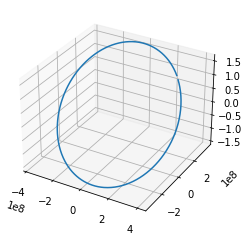

In [151]:
# Построим орбиту в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*rL)
pass

In [152]:
# Закроем файл эфемерид
f.close()

# Задача 3: найти точку входа в сферу действия Луны.
Радиус сферы действия луны примерно вычисляется по формуле $$r_{e}=r_{E-M}\Big(\frac{m_{M}}{m_{E}}\Big)^{\frac{2}{5}}$$  Согласно [ИПА РАН](http://iaaras.ru/en/dept/ephemeris/epm/2017/): $$\frac{m_{E}}{m_{M}}\approx81.300568886\Rightarrow\Big(\frac{m_{M}}{m_{E}}\Big)^{\frac{2}{5}}\approx0.172172017$$  Взяв в качестве $$r_{E-M}$$ среднее расстояние от Земли до Луны получим $$r_{e}\approx66\:194км$$ 

### Упр. 3: посчитать расстояние от Луны до КА и проверить вхождение в сферу действия Луны.

In [153]:
# Есть координаты и скорость Луны rL, VL, но пересчитаю их на нужную временную сетку
jd0 = 2459155 # 01.11.2020 12:00 UTC
step_max = 10 # сек
tf = 27*24*60*60 # Время интегрирования; Беру побольше, чем надо. Обрежу при расчётах.
dt = np.arange(0, tf + step_max, step_max) / (24*60*60)
jd0 = 2459155 + dt // 1
dt = dt % 1

ef = efm.CalcephBin.open("epm2017.bsp")
PV = ef.compute_unit(jd0, dt, efm.NaifId.MOON, efm.NaifId.EARTH, 
                    efm.Constants.UNIT_KM + efm.Constants.UNIT_SEC  + efm.Constants.USE_NAIFID)
PV = np.array(PV) # километры и секунды!
ef.close()

In [154]:
def f(t, x):
    r = np.linalg.norm(x[:3])
    r3 = r**3
    yr = constants.muE / r3
    result = np.empty(6)
    result[0] = x[3]
    result[1] = x[4]
    result[2] = x[5]
    result[3] = -x[0]*yr
    result[4] = -x[1]*yr
    result[5] = -x[2]*yr
    return result

In [155]:
# Спутник тоже отдельно пересчитаю тут, что бы не зависеть от предыдущих ячеек с кодом
# x0 смотрит на Луну в начальный момент времени, z0 - по моменту луны, y0 до правой тройки
# Это вспомогательные векторы, что бы КА летел в плоскости Луны
x0 = rL[:, 0]
x0 = x0/np.linalg.norm(x0)
z0 = np.cross(rL[:, 0], VL[:, 0])
z0 /= np.linalg.norm(z0)
y0 = np.cross(z0, x0)

t0 = 0
tf = 8*24*60*60
step_max = 10
tolerance = 1e-10
t_eval = np.arange(t0, tf + step_max, step_max)
Rinit = constants.RE + 400e3 # Начальное расстояние от центра Земли
Vinit = 10760 # Начальная скорость
f0 = np.array([*(x0 * Rinit), *(y0 * Vinit)])

res = solve_ivp(f, (t0, tf), f0, t_eval = t_eval, rtol = tolerance, atol = tolerance).y

In [156]:
R = res[0:3]
V = res[3:]
RL = PV[:3, :R.shape[1]] * 1e3 # 1e3 для перевода в м/c
VL = PV[3:, :V.shape[1]] * 1e3

In [157]:
# Расстояние КА-Луна
d = np.linalg.norm(RL - R, axis = 0)
re = 66194e3

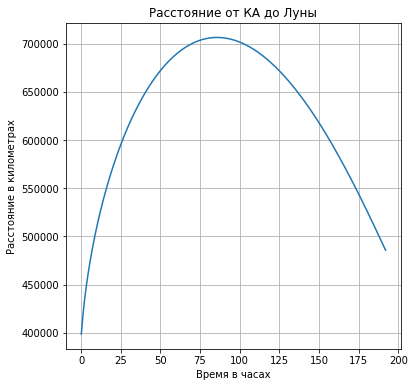

In [158]:
# Посмотрим на эволицию расстояния КА-Луна
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6)

axes.plot(t_eval/60/60, d/1e3)
axes.set_title("Расстояние от КА до Луны")
axes.set_xlabel("Время в часах")
axes.set_ylabel("Расстояние в километрах")
axes.grid(True)

In [159]:
# Проверим, есть ли места вхождения КА в радиус сферы действия
np.any(d < re)

False

In [160]:
# Значит, нужно выбрать другие начальные данные
# Буду запускать в той же плоскости с той же скоростью и высотой, но буду поворачивать радиус-вектор начального положения
# Скорость считаю ортогональной ему
da = 10 / 180 * np.pi # Буду поворачивать по 10 Градусов
a = -da
d = 2*re
while(not np.any(d < re)):
    a += da    
    r0 = x0 * np.cos(a) + y0 * np.sin(a)
    V0 = x0 * -np.sin(a) + y0 * np.cos(a)
    f0 = np.array([*(r0 * Rinit), *(V0 * Vinit)])
    
    res = solve_ivp(f, (t0, tf), f0, t_eval = t_eval, rtol = tolerance, atol = tolerance).y
    R = res[0:3]
    
    d = np.linalg.norm(RL - R, axis = 0)

In [161]:
print("Найденный угол:", a / np.pi * 180, "градусов")

Найденный угол: 219.9999999999999 градусов


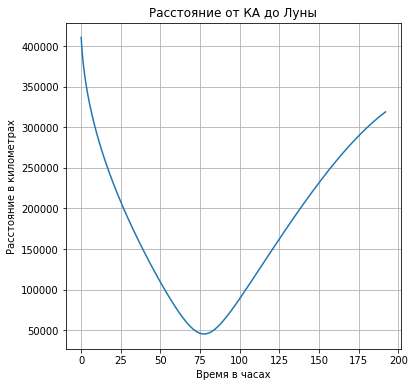

In [162]:
# Построим опять график
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6)

axes.plot(t_eval/60/60, d/1e3)
axes.set_title("Расстояние от КА до Луны")
axes.set_xlabel("Время в часах")
axes.set_ylabel("Расстояние в километрах")
axes.grid(True)

In [163]:
# Хочу посмотреть сколько времени КА находится в сфере действия Луны (считая, что она на него не влияет)
print("В сфере действия Луны КА проводит:", np.sum(d < re) * 10 / 60 / 60, "часов") #1 шаг по времени - 10 сек
print("Минимальное расстояние до центра Луны:", np.min(d) / 1e3, "км")

В сфере действия Луны КА проводит: 27.67222222222222 часов
Минимальное расстояние до центра Луны: 45398.69040175991 км


In [164]:
# В какой момент времени КА вошёл в сферу действия Луны
ind = np.min(np.where(d < re)) # Этот индекс нам ещё понадобится!
print("Вошёл в сферу действия Луны через", ind * step_max / 60 / 60, "часов полёта")

Вошёл в сферу действия Луны через 63.86666666666667 часов полёта


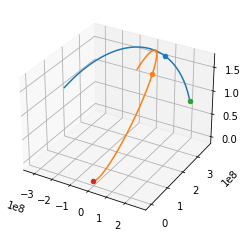

In [165]:
# Посмотрим результат. Синее - орбита Луны, оранжевое - КА
# Две точки синего и оранжевого цвета - положение Луны и КА в момент вхождения в сферу действия соответственно
# Зелёная и красная точки - начальные положения Луны и КА соответственно
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*RL)
ax.plot(*R)
ax.scatter(*(RL[:, ind]))
ax.scatter(*(R[:, ind]))
ax.scatter(*(RL[:, 0]))
ax.scatter(*(R[:, 0]))
pass

In [166]:
# Хочу посмотреть зависимость минимального расстояния от угла запуска (начиная с 210 и до 360)

a = np.arange(210, 360) / 180 * np.pi
d = []
for i in a:
    r0 = x0 * np.cos(i) + y0 * np.sin(i)
    V0 = x0 * -np.sin(i) + y0 * np.cos(i)
    f0 = np.array([*(r0 * Rinit), *(V0 * Vinit)])
    
    res = solve_ivp(f, (t0, tf), f0, t_eval = t_eval, rtol = tolerance, atol = tolerance).y
    R = res[0:3]
    
    d.append(np.min(np.linalg.norm(RL - R, axis = 0)))

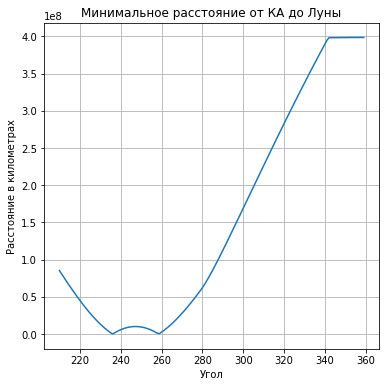

In [167]:
# Построим опять график
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6)

axes.plot(a/np.pi*180, d)
axes.set_title("Минимальное расстояние от КА до Луны")
axes.set_xlabel("Угол")
axes.set_ylabel("Расстояние в километрах")
axes.grid(True)

Для дайнейших рассчётов положу a = 230 градусов

In [183]:
V0

array([ 0.98469643,  0.17336874, -0.01778276])

In [168]:
a = 230/180 * np.pi
Rinit = constants.RE + 400e3 # Начальное расстояние от центра Земли
Vinit = 10760 # Начальная скорость
r0 = x0 * np.cos(a) + y0 * np.sin(a)
V0 = x0 * -np.sin(a) + y0 * np.cos(a)
f0 = np.array([*(r0 * Rinit), *(V0 * Vinit)])

t0 = 0
tf = 8*24*60*60
step_max = 10
tolerance = 1e-10
t_eval = np.arange(t0, tf + step_max, step_max)

res = solve_ivp(f, (t0, tf), f0, t_eval = t_eval, rtol = tolerance, atol = tolerance).y

In [169]:
R = res[0:3]
V = res[3:]
d = np.linalg.norm(RL - R, axis = 0)
re = 66194e3

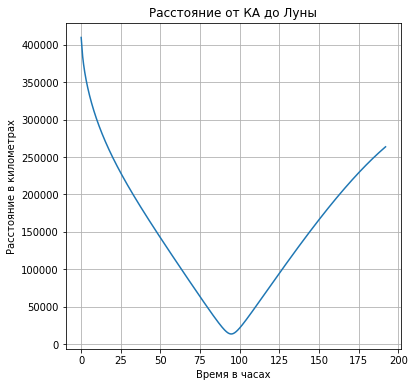

In [170]:
fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(6)

axes.plot(t_eval/60/60, d/1e3)
axes.set_title("Расстояние от КА до Луны")
axes.set_xlabel("Время в часах")
axes.set_ylabel("Расстояние в километрах")
axes.grid(True)

In [171]:
print("В сфере действия Луны КА проводит:", np.sum(d < re) * 10 / 60 / 60, "часов") #1 шаг по времени - 10 сек
print("Минимальное расстояние до центра Луны:", np.min(d) / 1e3, "км")
ind = np.min(np.where(d < re)) # Этот индекс нам ещё понадобится!
print("Вошёл в сферу действия Луны через", ind * step_max / 60 / 60, "часов полёта")

В сфере действия Луны КА проводит: 41.46388888888889 часов
Минимальное расстояние до центра Луны: 13426.15079703111 км
Вошёл в сферу действия Луны через 74.06388888888888 часов полёта


In [181]:
t_eval[ind]

266630

# Задача 4: рассчитать относительную скорость. Отрисовать картинную плоскость.
После моделирования полёта КА был найден момент вхождения КА в сферу действия Луны. Далее будем рассматривать задачу двух тел Луна - КА, но для этого необходимо рассчитать скорость КА относительно Луны. Так же необходимо отрисовать картинную плоскость, т.к. это крайне удобный инструмент для проектирования пролёта КА.

In [28]:
# Заданы RL0, VL0, R0, V0 - положение, скорости Луны и КА в момент входа КА в сферу действия Луны соответственно
# t0 - время входа в сферу действия
RL0 = RL[:, ind]
VL0 = VL[:, ind]
R0 = R[:, ind]
V0 = V[:, ind]
t0 = t_eval[ind]

In [29]:
# Посчитаем относительные положение и скорость
Rinf = R0 - RL0
Vinf = V0 - VL0

In [30]:
np.linalg.norm(Vinf)

873.2467533884728

## Вопрос построения картинной плоскости
Картинная плоскость проходит через центр Луны и строится ортогонально вектору относительной скорости КА. Для того, что бы задать плоскость необходимо задать базис на этой плоскости (относительно нашей ИСК свзяанной с Землёй), а дополнив его третьим вектором до правой тройки получим ИСК (в плане того, что базисные векторы не вращаются, но начало отсчёта, очевидно, будет двигаться, да ещё и с ускорением, но этим пренебрегаем) связанную с Луной.  
Я буду опираться на диссертацию [Nathan J. Strange](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=2044&context=open_access_dissertations) и введу базис так: $$\textbf{e}_{3}=\frac{\textbf{U}_{inf}}{U_{inf}}\\\textbf{e}_{1}=\frac{\textbf{e}_{3}\times\textbf{p}_{3}}{|\textbf{e}_{3}\times\textbf{p}_{3}|}\:where\:\textbf{p}_{3}=\textbf{R}_{L}\times\textbf{V}_{L}\\\textbf{e}_{2}=\textbf{e}_{3}\times\textbf{e}_{1}$$  
Сама же плоскость образуется векторами **e**<sub>1</sub> и **e**<sub>2</sub>

In [31]:
e3 = Vinf/np.linalg.norm(Vinf)
p3 = np.cross(RL0, VL0)
p3 /= np.linalg.norm(p3) # сразу нормирую
e1 = np.cross(e3, p3)
e1 /= np.linalg.norm(e1) # нормирую ещё раз
e2 = np.cross(e3, e1)
e2 /= np.linalg.norm(e2) # нормирую на всякий случай

In [32]:
# Проверю нормировку
np.linalg.norm(e1), np.linalg.norm(e2), np.linalg.norm(e3)

(0.9999999999999999, 1.0, 1.0)

In [33]:
# Необхожимо вычислить матрицу перехода
# Я вычисляю её изначально как в линейной алгебре - составлена и столбцов e1, e2, e3
# Т.к. в данном случае это, по факту, матрица поворота, обратная к ней есть она же, но транспонированная
# Далее матрица M это матрица, такая что Rnew = M*Rold
M = np.array([e1, e2, e3]) # в силу особенностей работы numpy эта матрица и состоит из строк e1, e2, e3

In [34]:
# Переведу все векторы в новую систему координат и буду работать в ней
RL0 = M @ RL0
VL0 = M @ VL0
R0 = M @ R0
V0 = M @ V0
Rinf = M @ Rinf
Vinf = M @ Vinf

In [35]:
# Посмотрю на относительную скорость, она должна быть направлена строго вдоль e3
print(Vinf)
# Из-за ошибок округления есть небольшие e1 и e2 компоненты. Занулю их вручную
Vinf[0] = 0
Vinf[1] = 0

[-1.42108547e-14  1.42108547e-14  8.73246753e+02]


Теперь необходимо найти *pircing-point* - точку, где вектор **V**<sub>inf</sub> пересекает картинную плоскость. Положение этой точки буду задвать вектором **B**, лежащем в этой плоскости. Найти вектор **B** несложно - это проекция радиус-вектора КА относительно Луны на картинную плоскость. Т.к. я уже перевёл относительное положение **R**<sub>inf</sub> в базис, связанный с картинной плоскость, то координаты вектора **B** будут совпадать с первыми двумя координатами вектора **R**<sub>inf</sub> в этом базисе.
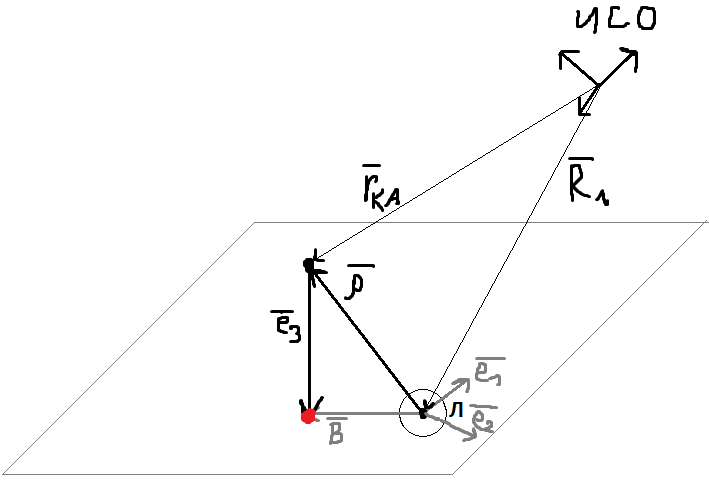  
Также необходимо рассчитать параметры орбиты и расстояние до Луны в перицентре, для чего сначала рассчитаю первые интегралы задачи двух тел.

In [36]:
B = np.array([Rinf[0], Rinf[1], 0])
C = np.cross(Rinf, Vinf)
c = np.linalg.norm(C)
h = np.linalg.norm(Vinf) ** 2 - 2 * constants.muL / np.linalg.norm(Rinf)

e = np.sqrt(1 + h * c**2 / constants.muL**2)

In [37]:
print("Eccentricity =", e)

Eccentricity = 1.9607070920635123


In [38]:
# Орбита, очевидно, гиперболическая. Посчитаю фокальный параметр и рассттояние перицентра
p = c**2 / constants.muL
rp = p / (e + 1)

In [39]:
print("Расстояние перицентра:", rp / 1e3, "км")
print("Высота в перицентре:", (rp - constants.RL)/1e3, "км")

Расстояние перицентра: 7666.134742846617 км
Высота в перицентре: 5929.134742846617 км


In [40]:
# Хочу посмотреть что будет, если немного поменять Vinf
Vinf2 = Vinf.copy()
dVinf = 10
Vinf2[2] += dVinf

C2 = np.cross(Rinf, Vinf2)
c2 = np.linalg.norm(C2)
h2 = np.linalg.norm(Vinf2) ** 2 - 2 * constants.muL / np.linalg.norm(Rinf)

e2 = np.sqrt(1 + h2 * c2**2 / constants.muL**2)
p2 = c2**2 / constants.muL
rp2 = p2 / (e + 1)

In [41]:
print(f"Изменение высоты перицентра при изменении Vinf на {dVinf} м/с равно", (rp2 - rp)/1e3, "км")

Изменение высоты перицентра при изменении Vinf на 10 м/с равно 176.58305968874228 км


Настало время отрисовать картинную плоскость и отметить на ней *pircing-point* и различные изолинии.

In [42]:
size = int(np.round(rp/1e3 * 6))

# Круг - контур Луны (взят средний радиус Луны)
circle = plt.Circle((0, 0), constants.RL / 1e3, color = "grey")

# pircing-point
pp = plt.Circle((B[0]/1e3, B[1]/1e3), step * 30, color = "red")

# Изолинии. Считаю постоянными Vinf -> h
rps = np.array([rp / 4, rp / 2, rp, rp * 2, rp * 3, rp * 4, rp * 5]) # высоты для отрисовки
b = rps * np.sqrt(h + 2 * constants.muL / rps) / Vinf[2] # |Vinf| = Vinf[2] т.к. оно строго вдоль оси e3
cmap = matplotlib.cm.get_cmap('viridis')
n = b.shape[0]
circles = [plt.Circle((0, 0), b[i]/1e3, color = cmap(i * 1/(n - 1)), fill = False) for i in range(0, n)]
patched = PatchCollection(circles, match_original = True)

In [43]:
tau = np.array([B[0]/1e3, B[1]/1e3])
tau /= np.linalg.norm(tau)
points_to_annotate = np.array([i/1e3 * tau for i in b])
annotations = np.array(['{0:,}'.format(decimal.Decimal(int(i/1e3))).replace(',', ' ') for i in (rps - constants.RL)])
text_coords = np.full(points_to_annotate.shape, (2, 2))

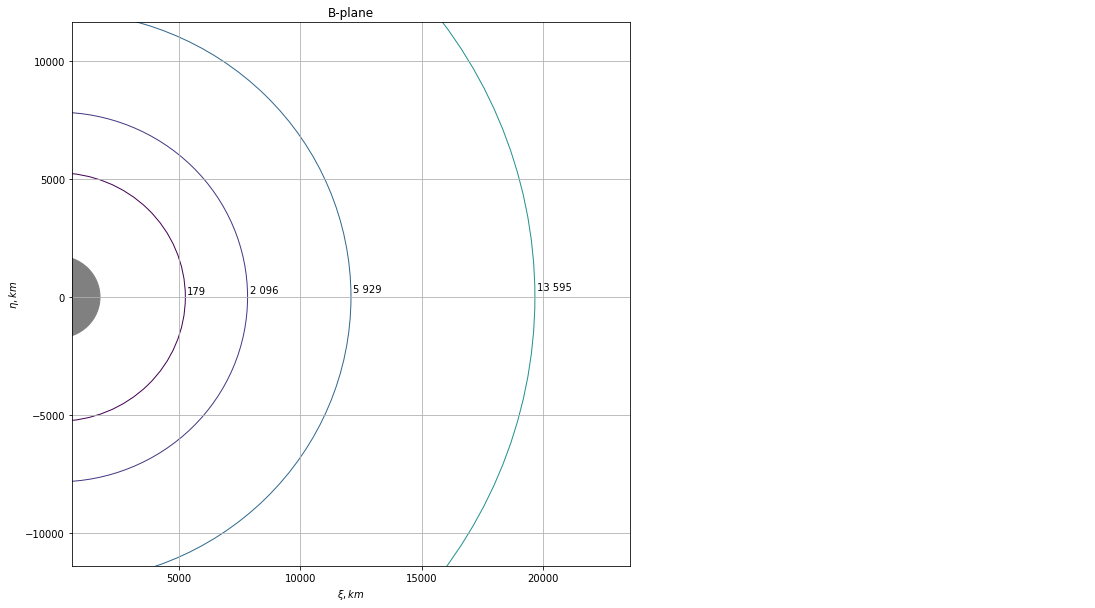

In [44]:
figP, axesP = plt.subplots(1)
figP.set_figheight(10)
figP.set_figwidth(10)

axesP.set_xbound((-size/4 + B[0]/1e3, size/4 + B[0]/1e3))
axesP.set_ybound((-size/4 + B[1]/1e3, size/4+ B[1]/1e3))

axesP.add_artist(circle)

axesP.add_artist(pp)

axesP.add_collection(patched)


axesP.set_title("B-plane")
axesP.set_xlabel("$\\xi, km$")
axesP.set_ylabel("$\eta, km$")
axesP.grid(True)

# labels = [f"{np.int(i/1e3)//1000} {np.int(i/1e3)%1000}"for i in rps]
# axesP.legend(circles, labels, title = "rp, km", loc=(1.01,0.5))

for i in range(annotations.shape[0]):
    axesP.annotate(annotations[i], xy = points_to_annotate[i], textcoords = 'offset pixels', xytext = text_coords[i])
pass

In [45]:
rinf = np.array([*Rinf, *Vinf])

In [46]:
# Далее перенесу отсюда часть данных в качестве тестовых 
# в следующий блок про построение эллипсосв
with open("trajectory.npy", 'wb') as f:
    np.save(f, res)

with open("rinf.npy", 'wb') as f:
    np.save(f, rinf)
    
with open("time_points.npy", 'wb') as f:
    np.save(f, t_eval)

with open("enter_index.npy", 'wb') as f:
    np.save(f, ind)
    
with open("M.npy", 'wb') as f:
    np.save(f, M)